<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Walk_on_Boundary_and_BIEM/WalkOnBoundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
from jax import lax
from jax import random

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt
import pandas as pd

# Boundary Functions

In [ ]:
'''
signed distance function of the domain
'''
@jax.jit
def signDistance(p):
  return jnp.linalg.norm(p,ord=2,axis=1,keepdims=True) - 1 # unit sphere

In [ ]:
'''
bounding box diameter
'''
@jax.jit
def box():
  return 2

In [ ]:
'''
Dirchlet boundary condition
'''
@jax.jit
def boundaryCond(p, k):
  pointCharge = jnp.array([[0,0,2]])
  pointCharge = jnp.tile(pointCharge, (1, jnp.size(p,0)))
  pointCharge = pointCharge.reshape(jnp.size(p,0), jnp.size(p,1), 1) # [solutions, dimensions, samples]
  pDiff = jnp.linalg.norm(p - pointCharge, ord=2, axis=1)
  return jnp.exp(-k * pDiff) / (4 * jnp.pi * pDiff)

In [ ]:
'''
the true solution
'''
@jax.jit
def trueSoln(p, k):
  pointCharge = jnp.array(jnp.size(p,0)*[0,0,2]).reshape(jnp.size(p,0),jnp.size(p,1)) # [solutions, dimensions]
  pDiff = jnp.linalg.norm(p - pointCharge, ord=2, axis=1)
  return jnp.exp(-k * pDiff) / (4 * jnp.pi * pDiff)

# WOB algorithm

In [ ]:
'''
binary search to find boundary intersection
'''
@jax.jit
def binaryRootSearch(p0, p1, rootSteps, dir):
  p1 = p0 + p1 # need to center p1 at p0

  current = jnp.zeros((jnp.size(p0, 0), 1, jnp.size(p0, 2))) # [solutions, dimensions, samples]

  def binaryStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist = signDistance(p0 + dir * next * (p1 - p0))
    return jnp.where(dist > 0, current, next)

  current = lax.fori_loop(0, rootSteps, binaryStep, current)
  
  
  return p0 + dir * current * (p1 - p0), current # return [roots, t-values]

In [ ]:
'''
run the wob and calculate the estimator
'''
@jax.jit
def wob(p0, p1, t, rootSteps, k):
  runningEst = jnp.zeros((jnp.size(p0,0),jnp.size(p0,2))) # [solutions, samples]
  runningSign = 1
  
  pNext, tFirst = binaryRootSearch(p0, p1[0], rootSteps, 1)
  
  pDiff = jnp.linalg.norm(p0 - pNext, ord=2, axis=1)
  qNext = jnp.exp(-k * pDiff) * (1 + k * pDiff)
  pBefore = pNext

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext, k) * qNext
    runningSign *= -1
    
    pBack, tBack = binaryRootSearch(pNext, p, rootSteps, -1)
    pFor, tFor = binaryRootSearch(pNext, p, rootSteps, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)
    
    pDiff = jnp.linalg.norm(pBefore - pNext, ord=2, axis=1)
    qNext = qNext * jnp.exp(-k * pDiff) * (1 + k * pDiff)
    pBefore = pNext

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext, k) * qNext
  return runningEst

In [ ]:
'''
setup the wob
'''
def computeSoln(t, rootSteps, samples, k, p, key):
  p = jnp.reshape(p, (jnp.size(p,0), jnp.size(p,1), 1))
  p0 = jnp.tile(p, (1,1,samples)) # [solutions, dimensions, samples]

  # generate random directions in n-dimensions
  p1 = random.normal(key, shape=(t, jnp.size(p, 0), jnp.size(p, 1), samples))
  normalize = jnp.linalg.norm(p1, ord=2, axis=1, keepdims=True)
  p1 = box() * jnp.divide(p1, normalize) # [jumps, solutions, dimensions, samples]

  ans = wob(p0, p1, t, rootSteps, k)
  return jnp.mean(ans, 1, keepdims=True), jnp.std(ans, 1, keepdims=True)

# Testing

In [ ]:
%%time
'''
testing code
'''
key = random.PRNGKey(int(time.time()))
#x = jnp.array([[0,0,0.1], [0,0,0.3]])
x = jnp.array([[-0.3,0.5,0.8]])

y, sd = computeSoln(10, 5, 100000, 1, x, key)
print('solution:', y)
print('exact:', trueSoln(x, 1))

solution: [[0.01579609]]
exact: [0.01570938]
CPU times: user 201 ms, sys: 7.09 ms, total: 208 ms
Wall time: 149 ms


# Datasets

In [ ]:
'''
generate dataset with throw-out algorithm
WARNING: this algorithm gets worse in higher dimensions
'''
def generateData():
  key = random.PRNGKey(0)
  dimensions = 2
  samples = 10000
  x = random.uniform(key, minval=-box()/2, maxval=box()-box()/2, shape=(samples,dimensions))
  indices = jnp.where(signDistance(x.transpose()) < 0)
  print('kept', len(x[indices]), 'out of', len(x))
  x = x[indices]

  batchSize = 100
  y, std = computeSoln(10, 15, 100000, x[:batchSize], key)
  for i in range(batchSize, len(x), batchSize):
    mean, std = computeSoln(5, 10, 100000, x[i:i+batchSize], key)
    y = np.concatenate((y, mean), axis=0)
  
  return x, y

In [ ]:
'''
save the dataset
'''
def saveData(x,y):
  np.savez('wob_piecwise_data', x=x, y=y)

In [ ]:
x, y = generateData()
saveData(x,y)

In [ ]:
'''
download the dataset
'''
def downloadData():
  data = np.load('wob_piecwise_data.npz')
  return data['x'], data['y']

# Graphing

Text(0.5, 1.0, 'walk on boundary for screened poisson equation')

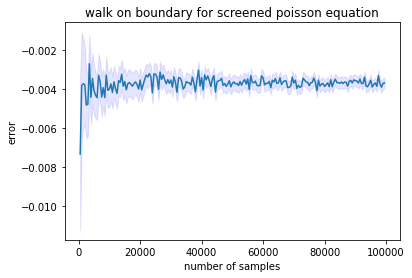

In [ ]:
'''
plot the data
'''
t = 5
#t = np.arange(2,50)
rootSteps = 15
#batches = np.power(10,np.arange(1,7))
#batches = 100000
batches = np.arange(500, 100000, 500)
y = jnp.array([[0,0,-0.3]])

key = random.PRNGKey(int(time.time()))
keys = random.split(key, len(batches))

values = np.zeros(len(batches))
sdValues = np.zeros(len(batches))
for i in range(len(batches)):
  values[i], sdValues[i] = computeSoln(t, rootSteps, batches[i], y, keys[i])


upperC = values + 1.96 * sdValues / np.sqrt(batches)
lowerC = values - 1.96 * sdValues / np.sqrt(batches)
error = values - trueSoln(y)
plt.plot(batches, error)
#plt.xscale('log')
#plt.yscale('log')
plt.fill_between(batches, lowerC-trueSoln(y), upperC-trueSoln(y), color='b', alpha=.1)
plt.xlabel('number of samples')
plt.ylabel('error')
plt.title('walk on boundary for screened poisson equation')